In [1]:
import sys
import ocel
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from pprint import pprint 
from statistics import mean

from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA


from ocel_features.graphs import read_object_centric_graph
from ocel_features.obj.object_situation import Targets, create_situations
from ocel_features.decompositions import log_time_decomposition, Decompositions
from ocel_features.series import convert_series_absolute_differences, convert_series_relative_differences
from ocel_features.analysis.plot_graphs import show_graph_plt, save_graph_graphviz
from ocel_features.analysis.plot_data import plot_time_series_wavelet

In [2]:
def add_oe_to_graph(log, graph):
    for k, v in log["ocel:events"].items():
        for oid in v["ocel:omap"]:
            if 'object_events' not in graph.nodes[oid]:
                graph.nodes[oid]['object_events'] = []
            graph.nodes[oid]['object_events'].append(k)

In [3]:
# import log
log = ocel.import_log("thesis-example.jsonocel")

# import object features
object_point = pd.read_csv("object-point.csv", sep="|")
object_group = pd.read_csv("object-group.csv", sep="|")

# import event features
event_point = pd.read_csv("event-point.csv", sep="|")
event_group = pd.read_csv("event-group.csv", sep="|")


In [4]:
# import all relations graph
ocdg = read_object_centric_graph("thesis-example-whole.gml")
ocdg_decomposed = read_object_centric_graph("thesis-example-decomposed.gml")

add_oe_to_graph(log, ocdg)
add_oe_to_graph(log, ocdg_decomposed)

In [408]:
# import descendants graph & decomposed version
ocdg_descendants = read_object_centric_graph("thesis-example-descendants-decomposed.gml")
# ocdg_descendants_decomposed = read_object_centric_graph("thesis-example-decomposed-dependency.gml")

add_oe_to_graph(log, ocdg_descendants)
# add_oe_to_graph(log, ocdg_descendants_decomposed)

In [7]:
# import descendants+cobirth relations graph & decomposed version
ocdg_cb_desc_decomposed = read_object_centric_graph("descendants-cobirth-decomposed.gml")

add_oe_to_graph(log, ocdg_cb_desc_decomposed)

In [418]:
# whole data
print("Whole Graph metadata")
print("Number of nodes:", ocdg.number_of_nodes())
print("Number of edges:", ocdg.number_of_edges(), "\n")

# decomposed data
print("Decomposed Graph metadata")
print("Number of nodes:", ocdg_decomposed.number_of_nodes())
print("Number of edges:", ocdg_decomposed.number_of_edges(), "\n")

# cb+desc decomposed data
print("Decomposed Graph metadata")
print("Number of nodes:", ocdg_cb_desc_decomposed.number_of_nodes())
print("Number of edges:", ocdg_cb_desc_decomposed.number_of_edges())

Whole Graph metadata
Number of nodes: 61301
Number of edges: 914370 

Decomposed Graph metadata
Number of nodes: 61301
Number of edges: 847811 

Decomposed Graph metadata
Number of nodes: 61301
Number of edges: 146962


In [422]:
# get subgraphs from cb+desc decomposition
sub_combo = list(nx.weakly_connected_components(ocdg_cb_desc_decomposed))
print(sum([1 for s in sub_combo[0] if s[0] == 'p']))
print(sum([1 for s in sub_combo[0] if s[0] == 'i']))
print(sum([1 for s in sub_combo[0] if s[0] == 'r']))
print(sum([1 for s in sub_combo[0] if s[0] == 'o']))

45
144
4
71


In [421]:
# get subgraphs from desc decomposition
sub_desc = list(nx.weakly_connected_components(ocdg_descendants))
print(sum([1 for s in sub_desc[0] if s[0] == 'p']))
print(sum([1 for s in sub_desc[0] if s[0] == 'i']))
print(sum([1 for s in sub_desc[0] if s[0] == 'r']))
print(sum([1 for s in sub_desc[0] if s[0] == 'o']))

10
36
1
0


In [11]:
# employee analysis
# extract employee objects
employees = [k for k, v in log["ocel:objects"].items() if v["ocel:type"] == "employee"]

# extract employee object point
employee_df = object_point[object_point['oids'].isin(employees)]
employee_index = pd.DataFrame(employee_df['oids'])
employee_df = employee_df.drop('oids', axis=1)

# feature selection based on trees
feature_embeddings = PCA(n_components=2)
pca_features = feature_embeddings.fit_transform(employee_df)

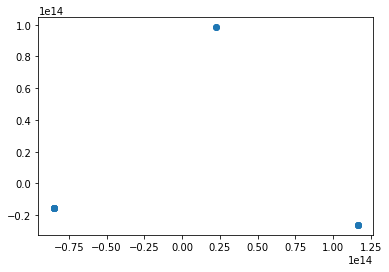

In [12]:
plt.scatter(pca_features.T[0], pca_features.T[1])

In [376]:
kmeans_employee = KMeans(n_clusters=3, random_state=123).fit(pca_features)
employee_index['cluster'] = kmeans_employee.labels_
print(employee_index)

              oids  cluster
3636          Josh        2
8216          Kiki        1
9231          Pazu        0
9408      Penelope        0
10294      Resetti        1
11272  Pat Clifton        1
15702       Norton        1
21845        Jenny        2
22781        Julia        2
33652  Jack Danger        1
44702        Jacob        2
53186         Pete        1


In [ ]:
# with this information see who works most efficiently


In [377]:
### ACTIVITIES

In [19]:
# "deliver package" or "fail delivery"
params={'activities': {'fail delivery', 'deliver package'}}

# get all situations where either event occurs
situation_success = [k for k, v in log["ocel:events"].items() if v["ocel:activity"] == "deliver package"]
situation_fail = [k for k, v in log["ocel:events"].items() if v["ocel:activity"] == "fail delivery"]
print(len(situation_success), len(situation_fail))
situation_fail_events = {k: log["ocel:events"][k] for k in situation_fail}
situation_success_events = {k: log["ocel:events"][k] for k in situation_success}

9956 3019


In [20]:
# feature selection using trees
# X_df = event_point[event_point]
y = pd.DataFrame(["deliver package"]*len(situation_success)+["fail delivery"]*len(situation_fail))

In [21]:
# feature selection using trees
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)


NameError: name 'X' is not defined

In [22]:
Counter([v["ocel:activity"] for v in log["ocel:events"].values() if v["ocel:activity"] in params["activities"]])

Counter({'deliver package': 9956, 'fail delivery': 3019})

In [23]:
print(len(log["ocel:events"]))

186086


In [24]:
params={'activities': {'fail delivery', 'deliver package'}}

situations = create_situations(log, ocdg_cb_desc_decomposed, 
                               situation_fail_events, 
                               Targets.EVENTCHOICE, 
                               params)

In [25]:
situations_success = create_situations(log, ocdg_cb_desc_decomposed, situation_success_events, Targets.EVENTCHOICE, params)

In [407]:
relevant_events = {}
relevant_objects = {}
for k, v in situations_success[0]._events.items():
    if k == situations_success[1]._situation_event:
        relevant_events[k] = v
        break
    else:
        relevant_events[k] = v
        for o in v['ocel:omap']:
            if o not in relevant_objects:
                relevant_objects[o] = log['ocel:objects'][o]


In [423]:
package_sub = None
for s in sub:
    if 'r0' in s:
        package_sub = s
        break

situation_time = log['ocel:events'][situations_success[0]._situation_event]['ocel:timestamp']
objects_before = {x for x in s if log['ocel:events'][ocdg.nodes[x]['object_events'][0]]['ocel:timestamp']}
view = nx.subgraph_view(ocdg_descendants, filter_node=lambda x: x in package_sub)
# show_graph_plt(view)
# save_graph_graphviz(view)

True


In [433]:
# separate by week
sublogs = log_time_decomposition(log, Decompositions.TIME_SINGLE_WEEK_DAYS, params={'start_time': log['ocel:events']['e13']['ocel:timestamp'] , 'included_days': [1, 2, 3, 4, 5]})

# extract data
time_start = []
success_timeseries = []
fail_timeseries = []
combined = []

for sublog in sublogs:
    success_timeseries.append(len([1 for v in sublog['ocel:events'].values() if v['ocel:activity'] == 'deliver package']))
    fail_timeseries.append(len([1 for v in sublog['ocel:events'].values() if v['ocel:activity'] == 'fail delivery']))
    time_start.append(list(sublog['ocel:events'].values())[0]['ocel:timestamp'].date())
    
for success, fail in zip(success_timeseries, fail_timeseries):
    combined.append(success + fail)

In [434]:
df_time = pd.DataFrame()
df_time['time'] = time_start
df_time['success'] = success_timeseries
df_time['fail'] = fail_timeseries
df_time['combined'] = combined

In [435]:
df_time

,time,success,fail,combined
0,2022-02-01,0,0,0
1,2022-02-02,5,2,7
2,2022-02-03,12,3,15
3,2022-02-04,35,14,49
4,2022-02-05,45,10,55
...,...,...,...,...
170,2022-09-27,2,0,2
171,2022-09-28,97,21,118
172,2022-09-29,52,18,70
173,2022-09-30,78,26,104


<IPython.core.display.Javascript object>


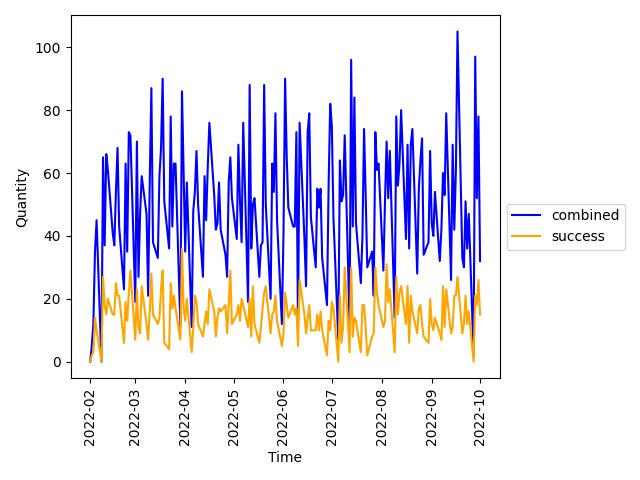

In [437]:
%matplotlib notebook
# show activities over time
plt.figure()
#sns.lineplot(x = 'time', y = 'combined', data = df_time, color = 'black')
sns.lineplot(x = 'time', y = 'success', data = df_time, color = 'blue')
sns.lineplot(x = 'time', y = 'fail', data = df_time, color = 'orange')
plt.xticks(rotation = 90)
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend(labels=['combined', 'success', 'fail'], bbox_to_anchor=(1,0.5))
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


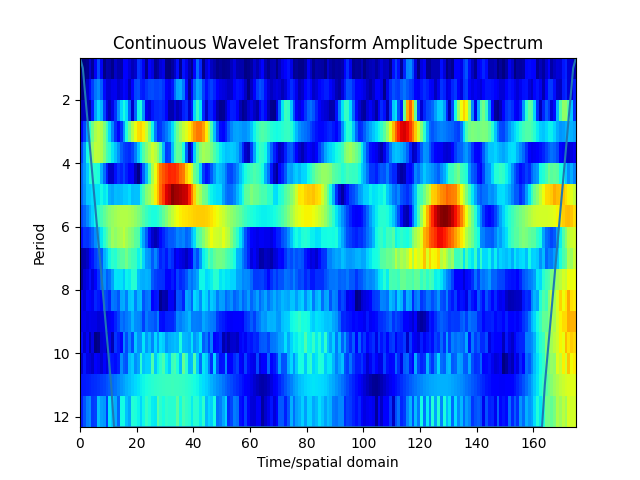

In [443]:
plot_time_series_wavelet(df_time['fail'])

<IPython.core.display.Javascript object>


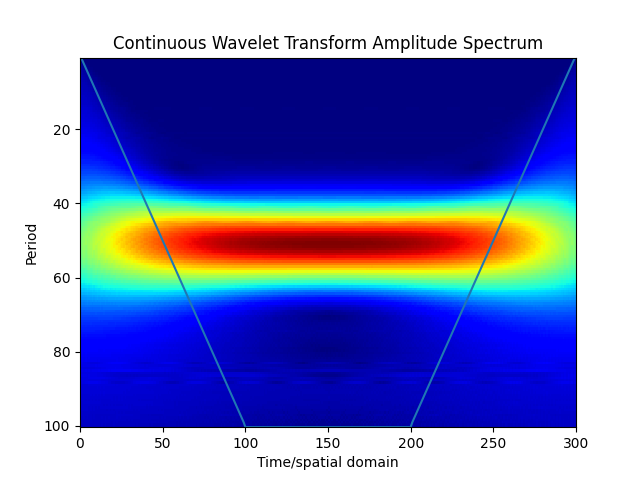

TypeError: alpha must be numeric or None, not a string

In [20]:
%matplotlib notebook

wave_time = np.arange(300)
freq = 1/50
ampl = 1

wave = ampl * np.cos((2 * np.pi * freq) * wave_time) 

import scaleogram as scg
scg.cws(wave_time, wave, scales=np.arange(1, 150), wavelet='cmor1-1.5')

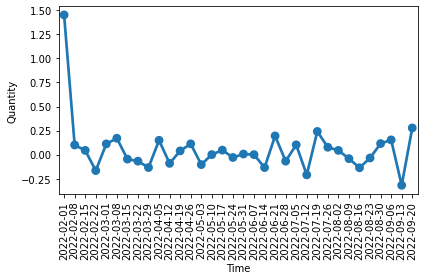

In [118]:
# differences plot
df_differences = pd.DataFrame()
df_differences['time'] = time_start[:-1]
df_differences['total_absolute'] = convert_series_absolute_differences(combined)
df_differences['total_relative'] = convert_series_relative_differences(combined)
df_differences['fail_absolute'] = convert_series_absolute_differences(fail_timeseries)
df_differences['fail_relative'] = convert_series_relative_differences(fail_timeseries)
df_differences['success_absolute'] = convert_series_absolute_differences(success_timeseries)
df_differences['success_relative'] = convert_series_relative_differences(success_timeseries)
plt.figure()
sns.pointplot(x = 'time', y = 'total_relative', data = df_differences)
plt.xticks(rotation = 90)
plt.xlabel('Time')
plt.ylabel('Quantity')
# plt.legend(labels=['combined', 'success', 'fail'], bbox_to_anchor=(1,0.5))
plt.tight_layout()
plt.show()

In [120]:
# check how routes are affected by package fail/
route_ids = [k for k in log['ocel:objects'] if k[0] == 'r']
driver_ids = ['Kiki', 'Pat Clifton', 'Pete', 'Jack Danger', 'Resetti', 'Norton']

In [129]:
route_success_number = [0]*len(route_ids)
route_fail_number = [0]*len(route_ids)
route_success_ratio = [0.0]*len(route_ids)

for i, r in enumerate(route_ids):
    route_success_number[i] = len([k for k in ocdg.nodes[r]['object_events'] if log['ocel:events'][k]['ocel:activity'] == 'deliver package'])
    route_fail_number[i] = len([k for k in ocdg.nodes[r]['object_events'] if log['ocel:events'][k]['ocel:activity'] == 'fail delivery'])
    route_success_ratio[i] = route_success_number[i] / (route_success_number[i] + route_fail_number[i])
    


ok


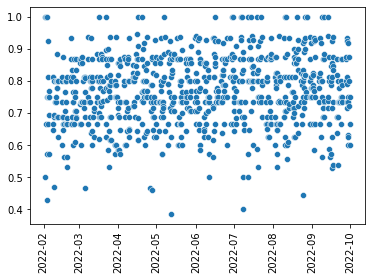

In [183]:
# success rate of routes over time
plt.figure()
sns.scatterplot(x = [log['ocel:events'][ocdg.nodes[r]['object_events'][0]]['ocel:timestamp'] for r in route_ids], y = route_success_ratio)
plt.xticks(rotation = 90)
print('ok')

In [160]:
# based on route destination
destinations = {i: [] for i in range(10)}
destination_list = []

driver = {d: [] for d in driver_ids}
driver_list = []

priority_list = []


for r in route_ids:
    first_event = ocdg.nodes[r]['object_events'][0]
    driver_id = [x for x in log['ocel:events'][first_event]['ocel:omap'] if x in driver_ids][0]
    all_packages = 
    one_package = [x for x in log['ocel:events'][first_event]['ocel:omap'] if x[0] == 'p'][0]
    first_package_event = ocdg.nodes[one_package]['object_events'][0]
    one_item = [x for x in log['ocel:events'][first_package_event]['ocel:omap'] if x[0] == 'i'][0]
    first_item_event = ocdg.nodes[one_item]['object_events'][0]
    one_order = [x for x in log['ocel:events'][first_item_event]['ocel:omap'] if x[0] == 'o'][0]
    dest = log['ocel:objects'][one_order]['ocel:ovmap']['Destination']
    
    
    
    driver_list.append(driver_id)
    driver[driver_id].append(r)
    
    destination_list.append(dest)
    destinations[dest].append(r)

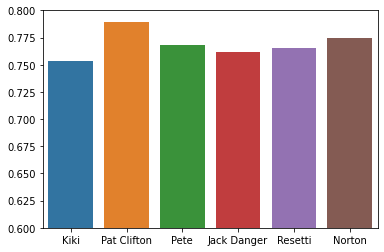

In [173]:
# based on driver
plt.figure()
sns.barplot(x = driver_ids, y = [mean([v for i, v in enumerate(route_success_ratio) if driver_list[i] == d]) for d in driver_ids])
plt.ylim(0.6, 0.8)
plt.show()

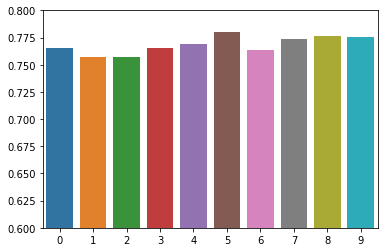

In [178]:
# based on destination
plt.figure()
sns.barplot(x = list(range(10)), y = [mean([v for i, v in enumerate(route_success_ratio) if destination_list[i] == d]) for d in range(10)])
plt.ylim(0.6, 0.8)
plt.show()

In [363]:
print(fail_only_count)

{'[1.0, 1.5)': [3349, 868, 209, 55, 20, 9, 6, 7, 9, 9], '[1.5, 2.0)': [870, 200, 51, 14, 4, 6, 6, 7, 8, 9], '[2.0, 2.5)': [1663, 364, 88, 17, 9, 6, 6, 7, 8, 9], '[2.5, 3]': [1896, 378, 69, 13, 7, 5, 6, 7, 8, 9]}


In [354]:
priorities = {i: [] for i in ['[1.0, 1.5)', '[1.5, 2.0)', '[2.0, 2.5)', '[2.5, 3]']}
priorities_keys = []
priorities_values = []
fail_only_count = {i: [j for j in range(10)] for i in priorities.keys()}
first_success_count = []

for p in [k for k in log['ocel:objects'] if k[0] == 'p']:
    prio = 0.0
    
    package_item_ids = [x for x in ocdg.neighbors(p) if x[0] == 'i']

    for i in package_item_ids:
        item_order  = [x for x in ocdg.neighbors(i) if x[0] == 'o'][0]
        prio += log['ocel:objects'][item_order]['ocel:ovmap']['Priority']

    prio = prio / len(package_item_ids)
    
    first_success = 0
    fail_count = 0
    for e in ocdg.nodes[p]['object_events']:
        if log['ocel:events'][e]['ocel:activity'] == 'deliver package':
            first_success = 1
        elif log['ocel:events'][e]['ocel:activity'] == 'fail delivery':
            fail_count += 1
    
    successes = len([x for x in ocdg.nodes[p]['object_events'] if log['ocel:events'][x]['ocel:activity'] == 'deliver package'])
    fails = len([x for x in ocdg.nodes[p]['object_events'] if log['ocel:events'][x]['ocel:activity'] == 'fail delivery'])

    try:
        deliver_success_rate = successes / (successes + fails)
    except ZeroDivisionError:
        deliver_success_rate = 0
        
    priorities_values.append(deliver_success_rate)
        
    if 1.0 <= prio < 1.5:
        priorities['[1.0, 1.5)'].append(deliver_success_rate)
        priorities_keys.append('[1.0, 1.5)')
        first_success_count.append(('[1.0, 1.5)', first_success))
        fail_only_count['[1.0, 1.5)'][fails] += 1
        
    elif 1.5 <= prio < 2:
        priorities['[1.5, 2.0)'].append(deliver_success_rate)
        priorities_keys.append('[1.5, 2.0)')
        first_success_count.append(('[1.5, 2.0)', first_success))
        fail_only_count['[1.5, 2.0)'][fails] += 1
    elif 2.0 <= prio < 2.5:
        priorities['[2.0, 2.5)'].append(deliver_success_rate)
        priorities_keys.append('[2.0, 2.5)')
        first_success_count.append(('[2.0, 2.5)', first_success))
        fail_only_count['[2.0, 2.5)'][fails] += 1
    else:
        priorities['[2.5, 3]'].append(deliver_success_rate)
        priorities_keys.append('[2.5, 3]')
        first_success_count.append(('[2.5, 3]', first_success))
        fail_only_count['[2.5, 3]'][fails] += 1
        

In [330]:
package_avg_success_by_item_priorities = {i: 0.0 for i in priorities.keys()}
package_avg_success_by_item_priorities |= {k: mean(v) for k, v in priorities.items() if len(v) > 0}
package_success_counter = Counter(first_success_count)

fail_only = []
for k in priorities.keys():
    fail_only.append(package_success_counter[(k, 0)] / (package_success_counter[(k, 0)] + package_success_counter[(k, 1)]))
   
pprint(package_success_counter)

Counter({('[1.0, 1.5)', 1): 4404,
         ('[2.5, 3]', 1): 2326,
         ('[2.0, 2.5)', 1): 2110,
         ('[1.5, 2.0)', 1): 1116,
         ('[1.0, 1.5)', 0): 92,
         ('[2.5, 3]', 0): 27,
         ('[2.0, 2.5)', 0): 22,
         ('[1.5, 2.0)', 0): 14})


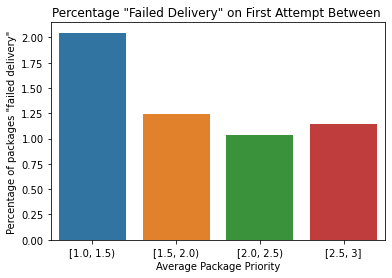

In [342]:
plt.figure()
sns.barplot(x = list(priorities.keys()), y = [x*100 for x in fail_only])
plt.title('Percentage "Failed Delivery" on First Attempt Between ')
plt.ylabel('Percentage of packages "failed delivery"')
plt.xlabel('Average Package Priority')
plt.show()

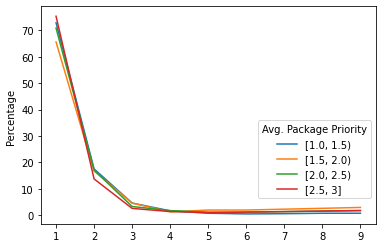

In [359]:
plt.figure()
for k, v in fail_only_count.items():
    sns.lineplot(x = list(range(10))[1:], y = [(o / sum(fail_only_count[k][1:]))*100 for o in v[1:]])


plt.legend(labels=list(fail_only_count), bbox_to_anchor=(1,0.5), title='Avg. Package Priority')
plt.ylabel('Percentage ')
plt.show()

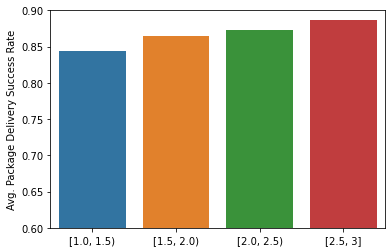

In [362]:
plt.figure()
sns.barplot(x = list(package_avg_success_by_item_priorities.keys()), y = list(package_avg_success_by_item_priorities.values()))
plt.ylabel('Avg. Package Delivery Success Rate')
plt.ylim(0.6, 0.9)
plt.show()